# Multi-Factor Strategy Backtesting with Machine Learning

This notebook implements a dynamic investment strategy based on a "Two-Stage Machine Learning" approach.
1. **Stage 1 (Market Regime):** Identifies the current market regime using macroeconomic data.
2. **Stage 2 (Factor Selection):** Selects the factors' weights specific to that market regime.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from collections import defaultdict

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
pd.set_option("display.max_columns", 50)

## Dataset Preparation

We start by loading the unified dataset containing temporally aligned macroeconomic variables. We set the date as the index to facilitate time-slicing operations during the backtest.

In [2]:
df = pd.read_csv("dataset_factor_prediction.csv") 
df = df.drop(columns=["best_factor"])
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
df = df.set_index("date")

We separate the target variable from the predictive variables. In this setup, we use the same set of macroeconomic indicators both to predict the market regime in Stage 1 and as inputs for the factor selection models in Stage 2.

In [3]:
target_regime_col = "market_regime"

stage1_feature_cols = [
    c for c in df.columns
    if c not in [target_regime_col]
]

stage2_feature_cols = stage1_feature_cols

In [4]:
df

,market_regime,cpilfesl,1 yr core cpi,10 yr-core cpi,gdpc1,gdp yoy%,GDP YoY%,nfcirisk,nfcicredit,nfcileverage,fedfunds,cape,earnings yield (ep),equity risk premium proxy: (e/p – 10yr yield),energy,financials,healthcare,consumer_staples,consumer_discretionary,utilities,industrials,telecom,materials,gs1,gs2,gs10
date,,,,,,,,,,,,,,,,,,,,,,,,,,
1994-01-01,0,154.500,2.912621,25.457991,10939.116,3.316913,3.430707,-1.08379,-0.47922,-0.30827,5.29,21.411975,0.046703,0.05750,-0.036435,-0.055669,-0.061834,-0.010436,-0.009915,-0.061372,-0.020356,-0.059392,-0.028812,0.0354,0.0414,0.0575
1994-02-01,0,154.800,2.971576,25.157233,10939.116,3.316913,3.430707,-0.96289,-0.52480,-0.25823,5.29,21.263840,0.047028,0.05970,-0.036435,-0.055669,-0.061834,-0.010436,-0.009915,-0.061372,-0.020356,-0.059392,-0.028812,0.0387,0.0447,0.0597
1994-03-01,1,155.300,2.962009,25.094103,10939.116,3.316913,3.430707,-0.78907,-0.52248,-0.29539,5.29,20.833376,0.048000,0.06480,-0.042946,-0.042350,-0.058534,-0.041859,-0.056363,-0.054472,-0.047056,-0.031477,-0.042874,0.0432,0.0500,0.0648
1994-04-01,1,155.500,3.151125,25.140713,11087.361,3.316913,4.225611,-0.68282,-0.44638,-0.43840,5.29,20.055250,0.049862,0.06970,0.046317,0.032109,0.031335,0.024034,-0.003287,0.008703,-0.011440,0.022185,-0.000824,0.0482,0.0555,0.0697
1994-05-01,1,155.900,3.078897,24.812968,11087.361,3.316913,4.225611,-0.68497,-0.37455,-0.53126,5.29,20.196492,0.049514,0.07180,-0.001775,0.050959,0.057632,-0.014477,-0.004617,-0.054675,0.006034,0.015897,0.040915,0.0531,0.0597,0.0718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,0,318.933,3.048603,35.848855,23478.570,2.783592,2.791390,-0.36354,0.00500,-0.09324,5.33,35.440000,0.028214,-0.01429,0.085638,0.043402,0.018446,0.006058,0.039492,0.012407,0.037648,0.007857,0.040583,0.0490,0.0450,0.0425
2024-08-01,1,319.839,3.112191,35.848855,23478.570,2.783592,2.791390,-0.38881,-0.00348,-0.24788,5.33,34.920000,0.028637,-0.01006,0.085638,0.043402,0.018446,0.006058,0.039492,0.012407,0.037648,0.007857,0.040583,0.0443,0.0397,0.0387
2024-09-01,0,320.835,3.025543,35.848855,23478.570,2.783592,2.791390,-0.41621,-0.03088,-0.33971,5.13,35.660000,0.028042,-0.00916,0.085638,0.043402,0.018446,0.006058,0.039492,0.012407,0.037648,0.007857,0.040583,0.0403,0.0362,0.0372


To train the supervised models for Stage 2, we must establish a posteriori which factor actually performed best in each month.
Here we load the historical factor returns, identify the monthly winner (`best_factor`), and create the necessary labels for training.

In [5]:
df_factor_returns = pd.read_csv("df_factors.csv")
df_factor_returns["date"] = pd.to_datetime(df_factor_returns["date"])
df_factor_returns = df_factor_returns.sort_values("date").set_index("date")

In [6]:
factor_names = ["value", "momentum", "quality", "low_vol", "growth"]

In [7]:
df_factor_returns["best_factor_name"] = df_factor_returns[factor_names].idxmax(axis=1)
factor_to_idx = {name: i for i, name in enumerate(factor_names)}
df_factor_returns["best_factor"] = df_factor_returns["best_factor_name"].map(factor_to_idx)

In [8]:
for f in factor_names:
    col_name = f + "_win"
    df_factor_returns[col_name] = (df_factor_returns["best_factor_name"] == f).astype(int)
df_factor_returns.index = (
    df_factor_returns.index.to_period("M").to_timestamp("D")
)

In [9]:
df_factor_returns
print(df_factor_returns["best_factor_name"].value_counts())

best_factor_name
quality     110
momentum     96
value        66
growth       54
low_vol      54
Name: count, dtype: int64


In [10]:
win_cols = [f + "_win" for f in factor_names]

df = df.merge(
    df_factor_returns[win_cols],
    left_index=True,
    right_index=True,
    how="left"
)

df = df.merge(
    df_factor_returns['best_factor'],
    left_index=True,
    right_index=True,
    how="inner"
)


## Preparation for Backtest

We define the simulation's temporal parameters:
* **Out-of-Sample (OOS) Period:** 2007-2025. This is the period over which we test the strategy "live".
* **Training Window:** 204 months (17 years). This is the historical depth used to train the models at each step.
* **Refit Frequency:** 1 month. Models are re-trained every month to incorporate the latest data.

In [11]:
oos_start = pd.Timestamp("2007-02-01")
oos_end   = pd.Timestamp("2025-01-31")
train_window_months = 12*17 
refit_frequency_months = 1  

In [12]:
def get_train_window(df, as_of_date, window_months):
    """
    Returns a training subset ending at as_of_date - 1 month,
    with length = window_months (or less at start of sample).
    """
    end_date = as_of_date - pd.offsets.MonthBegin(1)
    start_date = end_date - pd.DateOffset(months=window_months-1)
    train_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
    return train_df

We define the functions to build the classifiers:

* **Stage 1 (Market Regime):** Uses **XGBoost** to classify the next month as "Regime 0" (Normal) or "Regime 1" (Non Normal).
* **Stage 2 (Factor Selection):** Uses a **Stacking Ensemble** composed of:
    * *Base Level:* Random Forest, SVM, Gaussian Naive Bayes.
    * *Meta-Model:* Logistic Regression that learns to combine the base models' opinions.

In [13]:
def build_stage1_model(n_classes: int):
    """
    Build Stage 1 model, choosing objective based on number of distinct regimes.
    """
    if n_classes <= 2:
        clf = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=300,
            max_depth=3,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1,
        )
    else:
        clf = XGBClassifier(
            objective="multi:softprob",
            num_class=n_classes,          
            eval_metric="mlogloss",
            n_estimators=300,
            max_depth=3,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1,
        )

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf),
    ])
    return model

In [14]:
def build_binary_xgb():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=150,
            max_depth=3,
            subsample=0.7,
            colsample_bytree=0.7,
            learning_rate=0.05,
            n_jobs=-1,
        ))
    ])

In [15]:
def build_stage2_stacking():
    """
    Build the stacking ensemble for Stage 2:
    Base models: Random Forest, SVC, Gaussian Naive Bayes
    Meta model: Logistic Regression (multiclass, softmax)
    
    Returns a dict holding all model objects:
    {
        "rf":   RandomForestClassifier(),
        "svc":  SVC(),
        "gnb":  GaussianNB(),
        "meta": LogisticRegression()
    }
    """
    base_rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42
    )

    base_svc = SVC(
        kernel="rbf",
        probability=True,     
        C=1.0,
        random_state=42
    )

    base_gnb = GaussianNB()

    meta_lr = LogisticRegression(
        solver="lbfgs",
        max_iter=500
    )

    model = {
        "rf":   base_rf,
        "svc":  base_svc,
        "gnb":  base_gnb,
        "meta": meta_lr
    }

    return model

We implement helper functions to handle training on historical data.
For Stage 2, we train a separate set of models for each market regime. This allows the strategy to have different models specialized for calm or volatile market conditions.

In [16]:
def train_stage1(train_df):
    X = train_df[stage1_feature_cols]
    y = train_df[target_regime_col]

    unique_classes = y.nunique()
    print("Stage 1 unique regime classes:", unique_classes)
    print("Stage 1 class counts:\n", y.value_counts())

    if unique_classes < 2:
        print("Stage 1: Only one regime present → skip training")
        return None

    model = build_stage1_model(unique_classes)
    model.fit(X, y)
    return model

In [17]:
def train_stage2_per_regime(train_df, factor_names, feature_cols):

    models = {0: {}, 1: {}}   

    for regime in [0, 1]:

        df_reg = train_df[train_df["market_regime"] == regime]
        if df_reg.empty:
            continue

        y_true = df_reg["best_factor"].values
        X = df_reg[feature_cols].values

        model_reg = build_stage2_stacking()  

        for f_idx, f_name in enumerate(factor_names):
            y_binary = (y_true == f_idx).astype(int)

            base = {}
            base["rf"]  = RandomForestClassifier(n_estimators=200, random_state=42).fit(X, y_binary)
            base["svc"] = SVC(kernel="rbf", probability=True).fit(X, y_binary)
            base["gnb"] = GaussianNB().fit(X, y_binary)

            model_reg[f_idx] = base

        meta_X = []
        for f_idx in range(len(factor_names)):
            b = model_reg[f_idx]
            pr_rf  = b["rf"].predict_proba(X)[:,1]
            pr_svc = b["svc"].predict_proba(X)[:,1]
            pr_gnb = b["gnb"].predict_proba(X)[:,1]
            meta_X.append(np.column_stack([pr_rf, pr_svc, pr_gnb]))

        meta_input = np.hstack(meta_X)
        model_reg["meta"].fit(meta_input, y_true)

        models[regime] = model_reg

    return models

In [18]:
def predict_factor_in_regime(models_for_regime, X_row, factor_names):
    """Use 6 binary models to get probabilities."""
    probas = []

    for f in factor_names:
        if f in models_for_regime:
            p = models_for_regime[f].predict_proba(X_row)[0,1]
        else:
            p = 0.0  
        probas.append(p)

    return int(np.argmax(probas))

In [19]:
def predict_stage2_stacking(model_reg, X_row):
    """
    Predict factor winner using the stacking ensemble.
    model_reg: dict with keys 0..5 (base models per factor) + "meta"
    X_row: array of shape (1, n_features)
    Returns: (predicted_factor_index, probability_vector)
    """

    n_factors = len(factor_names)

    pr_list = []

    for f_idx in range(n_factors):
        base = model_reg[f_idx]

        pr_rf  = base["rf"].predict_proba(X_row)[0,1]
        pr_svc = base["svc"].predict_proba(X_row)[0,1]
        pr_gnb = base["gnb"].predict_proba(X_row)[0,1]

        pr_list.extend([pr_rf, pr_svc, pr_gnb])

    stack_input = np.array(pr_list).reshape(1, -1)

    proba_vec = model_reg["meta"].predict_proba(stack_input)[0]

    pred_factor = np.argmax(proba_vec)

    return pred_factor, proba_vec

## Rolling Backtest

In [20]:
factor_return_cols = [
  'best_factor',
  'value',
  'momentum',
  'quality',
  'low_vol',
  'growth'
]

df["market_regime"] = df["market_regime"].replace({2: 1}).astype(int)

This loop executes the simulation step-by-step:
1.  Iterates through every month of the test period (2007-2025).
2.  Selects the historical training window (e.g., 1994-2007).
3.  Trains the models (Regime Classifier + Factor Classifiers).
4.  Predicts the regime for month $t+1$.
5.  Selects the factor to buy based on the predicted regime.
6.  Records the realized return.

In [21]:
results = []
dates = df.loc[(df.index >= oos_start) & (df.index <= oos_end)].index
stage1_model = None
stage2_models = None
last_refit_date = None
factor_pred_count = defaultdict(int)
factor_true_count = defaultdict(int)
regime_pred_count = defaultdict(int)
factor_by_regime = defaultdict(lambda: defaultdict(int))

print("===== STARTING ROLLING BACKTEST (MULTICLASS STACKING) =====")

for current_date in dates:

    if (
        stage1_model is None
        or last_refit_date is None
        or ((current_date.to_period("M") - last_refit_date.to_period("M")).n >= refit_frequency_months)
    ):
        train_df = get_train_window(df, current_date, train_window_months)

        print("\n==============================")
        print("Refitting at", current_date.date())
        print("Training window:", train_df.index.min().date(), "→", train_df.index.max().date())
        print("Rows in training:", len(train_df))

        stage1_model = train_stage1(train_df)
        if stage1_model is None:
            print("Skipping this refit point: Stage 1 could not be trained.")
            continue

        stage2_models = train_stage2_per_regime(
            train_df,
            factor_names,
            stage2_feature_cols
        )

        last_refit_date = current_date

    X_t = df.loc[[current_date], stage1_feature_cols]
    regime_pred = int(stage1_model.predict(X_t)[0])

    if regime_pred in stage2_models:
        model_reg = stage2_models[regime_pred]

        factor_pred, factor_proba = predict_stage2_stacking(
            model_reg,
            df.loc[[current_date], stage2_feature_cols].values
        )
    else:
        factor_pred = 0
        factor_proba = np.array([1, 0, 0, 0, 0], dtype=float)

    if factor_pred >= len(factor_names):
        raise ValueError(f"Predicted factor index {factor_pred} outside valid range 0–{len(factor_names)-1}") 
    pred_name = factor_names[factor_pred]

    next_month_date = current_date + pd.offsets.MonthBegin(1)

    if next_month_date not in df_factor_returns.index:
        continue
    if next_month_date not in df.index:
        continue

    next_returns = df_factor_returns.loc[next_month_date, factor_names].values

    realized_return = float(np.dot(factor_proba, next_returns))

    weights_dict = {factor_names[i]: float(factor_proba[i]) for i in range(len(factor_names))}

    realized_regime = int(df.loc[next_month_date, "market_regime"])
    realized_best_factor = int(df.loc[next_month_date, "best_factor"])

    pred_name = factor_names[factor_pred]
    true_name = factor_names[realized_best_factor]

    factor_pred_count[pred_name] += 1
    factor_true_count[true_name] += 1
    regime_pred_count[regime_pred] += 1
    factor_by_regime[regime_pred][pred_name] += 1

    results.append({
        "date": next_month_date,
        "regime_pred": regime_pred,
        "regime_true": realized_regime,
        "factor_pred": factor_pred,
        "factor_true": realized_best_factor,
        "realized_return": realized_return,
        "weights": weights_dict,
    })


print("\n===== ROLLING BACKTEST COMPLETE =====")

print("\n===== Factor Prediction Usage =====")
for f in factor_names:
    print(f"{f:10s} predicted: {factor_pred_count[f]} times")

print("\n===== True Best Factors =====")
for f in factor_names:
    print(f"{f:10s} true winner: {factor_true_count[f]} times")

print("\n===== Regime Predictions =====")
for r, cnt in regime_pred_count.items():
    print(f"Regime {r}: {cnt} months")

print("\n===== Factor Predictions by Regime =====")
for r in factor_by_regime:
    print(f"\n--- Regime {r} ---")
    for f in factor_by_regime[r]:
        print(f"{f:10s}: {factor_by_regime[r][f]}")

===== STARTING ROLLING BACKTEST (MULTICLASS STACKING) =====

Refitting at 2007-02-01
Training window: 1994-02-01 → 2007-01-01
Rows in training: 156
Stage 1 unique regime classes: 2
Stage 1 class counts:
 market_regime
0    97
1    59
Name: count, dtype: int64

Refitting at 2007-03-01
Training window: 1994-02-01 → 2007-02-01
Rows in training: 157
Stage 1 unique regime classes: 2
Stage 1 class counts:
 market_regime
0    98
1    59
Name: count, dtype: int64

Refitting at 2007-04-01
Training window: 1994-02-01 → 2007-03-01
Rows in training: 158
Stage 1 unique regime classes: 2
Stage 1 class counts:
 market_regime
0    99
1    59
Name: count, dtype: int64

Refitting at 2007-05-01
Training window: 1994-02-01 → 2007-04-01
Rows in training: 159
Stage 1 unique regime classes: 2
Stage 1 class counts:
 market_regime
0    100
1     59
Name: count, dtype: int64

Refitting at 2007-06-01
Training window: 1994-02-01 → 2007-05-01
Rows in training: 160
Stage 1 unique regime classes: 2
Stage 1 class cou

# Benchmarks

## 8. Benchmark Integration

We compare our ML strategy results against standard market benchmarks:
* **S&P 500 (Cap-Weighted & Equal-Weighted):** To measure performance against the general market.
* **Fama-French (Equal-Weight):** A naive portfolio that invests uniformly in all factors (1/N), to see if ML adds value over simple diversification.

In [25]:
bt = pd.DataFrame(results).set_index("date")
bt.index = (
    bt.index.to_period("M")
            .to_timestamp("M")
            .date        
)

sp500 = pd.read_csv("sp500_benchmarks.csv")
sp500["date"] = pd.to_datetime(sp500["date"])
sp500["date"] = sp500["date"].dt.to_period("M").dt.to_timestamp("M")
sp500 = sp500.set_index("date").sort_index()

# bt = bt.loc[bt.index <= sp500.index.max()]

df_factor_returns.index = df_factor_returns.index + pd.offsets.MonthEnd(0)
df_factor_returns = df_factor_returns.sort_index()
df_factor_returns = df_factor_returns.loc[(df_factor_returns.index >= oos_start) & (df_factor_returns.index < oos_end)]

sp500 = sp500.loc[df_factor_returns.index]


# display(bt)
# display(sp500)
# display(sp500_vw)
display(df_factor_returns)

,growth,value,momentum,low_vol,quality,best_factor_name,best_factor,value_win,momentum_win,quality_win,low_vol_win,growth_win
date,,,,,,,,,,,,
2007-02-28,-0.022322,-0.016937,-0.024274,0.000634,-0.006045,low_vol,3,0,0,0,1,0
2007-03-31,0.009263,0.012999,0.014165,0.005916,0.002542,momentum,1,0,1,0,0,0
2007-04-30,0.046802,0.041965,0.031958,0.029479,-0.000974,growth,4,0,0,0,0,1
2007-05-31,0.031370,0.038187,0.024996,0.016364,0.005895,value,0,1,0,0,0,0
2007-06-30,-0.012384,-0.020550,-0.027950,-0.029446,0.011707,quality,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.021928,0.029606,0.037384,0.052126,0.009814,low_vol,3,0,0,0,1,0
2024-09-30,0.028368,0.011174,0.016342,0.010598,-0.011718,growth,4,0,0,0,0,1
2024-10-31,-0.006294,-0.012718,0.001103,-0.008795,-0.021051,momentum,1,0,1,0,0,0


In [26]:
factor_return_cols = ["value", "momentum", "quality", "low_vol", "growth"]
df_factor_returns["ew_portfolio"] = df_factor_returns[factor_return_cols].mean(axis=1)
ff6_eqw = df_factor_returns["ew_portfolio"].rename("bm_ff5_eqw")

sp500_vw = sp500["SP500_VW"].rename("bm_sp500_vw")

sp500_ew = sp500["SP500_EW"].rename("bm_sp500_ew")


best_ret = (
    df_factor_returns[factor_return_cols]
    .max(axis=1)
    .rename("best_in_hindsight")
)

bt = bt.join(ff6_eqw, how="left")
bt = bt.join(sp500_vw, how="left")
bt = bt.join(sp500_ew, how="left")
bt = bt.join(best_ret, how="left")

In [27]:
bt

,regime_pred,regime_true,factor_pred,factor_true,realized_return,weights,bm_ff5_eqw,bm_sp500_vw,bm_sp500_ew,best_in_hindsight
2007-03-31,0,0,2,1,0.008528,"{'value': 0.21428839022822302, 'momentum': 0.1...",0.008977,0.011000,0.007685,0.014165
2007-04-30,0,0,3,4,0.033916,"{'value': 0.20866669193774479, 'momentum': 0.3...",0.029846,0.043961,0.043207,0.046802
2007-05-31,0,0,0,0,0.028894,"{'value': 0.31768993017092134, 'momentum': 0.3...",0.023363,0.034393,0.032400,0.038187
2007-06-30,0,0,1,2,-0.021504,"{'value': 0.21724386684493047, 'momentum': 0.4...",-0.015725,-0.016658,-0.018536,0.011707
2007-07-31,0,1,1,2,-0.021659,"{'value': 0.18852985974217254, 'momentum': 0.2...",-0.024354,-0.030658,-0.043890,0.023045
...,...,...,...,...,...,...,...,...,...,...
2024-07-31,0,0,1,0,-0.007740,"{'value': 0.11438166575391992, 'momentum': 0.7...",0.008994,0.012148,0.044804,0.047453
2024-08-31,0,1,1,3,0.035958,"{'value': 0.045778741472771174, 'momentum': 0....",0.030172,0.024283,0.024943,0.052126
2024-09-30,0,0,0,4,0.012204,"{'value': 0.46919682096713367, 'momentum': 0.3...",0.010953,0.022581,0.022922,0.028368
2024-10-31,0,0,0,1,-0.007658,"{'value': 0.47765675374850186, 'momentum': 0.3...",-0.009551,-0.008690,-0.016410,0.001103


In [28]:
print(bt[["bm_ff5_eqw", "bm_sp500_ew", "realized_return"]].head())
print(bt[["bm_ff5_eqw", "bm_sp500_ew", "realized_return"]].describe())

            bm_ff5_eqw  bm_sp500_ew  realized_return
2007-03-31    0.008977     0.007685         0.008528
2007-04-30    0.029846     0.043207         0.033916
2007-05-31    0.023363     0.032400         0.028894
2007-06-30   -0.015725    -0.018536        -0.021504
2007-07-31   -0.024354    -0.043890        -0.021659
       bm_ff5_eqw  bm_sp500_ew  realized_return
count  213.000000   213.000000       213.000000
mean     0.008032     0.009509         0.007945
std      0.030405     0.052496         0.029006
min     -0.104040    -0.209466        -0.079707
25%     -0.009393    -0.018536        -0.008436
50%      0.012087     0.012286         0.012204
75%      0.028103     0.041894         0.028040
max      0.080601     0.185036         0.070178


In [29]:
print(bt.columns.tolist())

['regime_pred', 'regime_true', 'factor_pred', 'factor_true', 'realized_return', 'weights', 'bm_ff5_eqw', 'bm_sp500_vw', 'bm_sp500_ew', 'best_in_hindsight']


## Performance

We calculate key financial metrics for the strategy and benchmarks:
* Annualized Return
* Volatility
* Sharpe Ratio 
* Max Drawdown

In [30]:
def perf_summary(returns, name=""):
    rets = returns.dropna()
    if len(rets) == 0:
        return pd.Series(name=name)
    monthly_mean = rets.mean()
    monthly_std  = rets.std()
    ann_ret = (1 + monthly_mean)**12 - 1
    ann_vol = monthly_std * np.sqrt(12)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    cum = (1 + rets).prod() - 1
    dd = (1 + rets).cumprod()
    max_dd = (dd / dd.cummax() - 1).min()
    return pd.Series({
        "Ann. Return": ann_ret,
        "Ann. Vol": ann_vol,
        "Sharpe": sharpe,
        "Total Return": cum,
        "Max Drawdown": max_dd,
        "N months": len(rets),
    }, name=name)

summary = pd.concat([
    perf_summary(bt["realized_return"], "ML Strategy"),
    perf_summary(bt["bm_ff5_eqw"], "Fama French Equal-Weight"),
    perf_summary(bt["bm_sp500_ew"], "S&P 500 Equal-weight"),
], axis=1).T

print("=== Performance Summary (2007–2024) ===")
display(summary.round(3))

=== Performance Summary (2007–2024) ===


,Ann. Return,Ann. Vol,Sharpe,Total Return,Max Drawdown,N months
ML Strategy,0.100,0.100,0.991,3.937,-0.207,213.0
Fama French Equal-Weight,0.101,0.105,0.957,3.984,-0.322,213.0
S&P 500 Equal-weight,0.120,0.182,0.661,4.596,-0.557,213.0


We compare the our strategy with the benchmarks and the single factors.

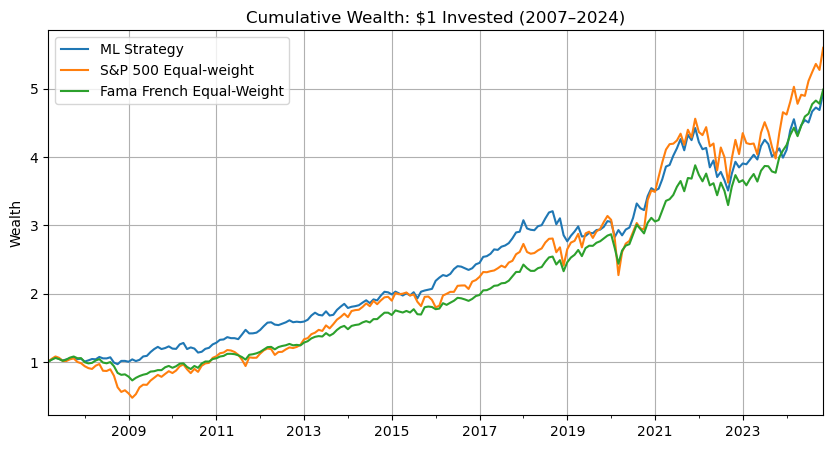

In [31]:
equity = pd.DataFrame(index=bt.index)
equity["ML Strategy"] = (1 + bt["realized_return"]).cumprod()
equity["S&P 500 Equal-weight"] = (1 + bt["bm_sp500_ew"]).cumprod()
equity["Fama French Equal-Weight"] = (1 + bt["bm_ff5_eqw"]).cumprod()

equity.plot()
plt.title("Cumulative Wealth: $1 Invested (2007–2024)")
plt.ylabel("Wealth")
plt.show()

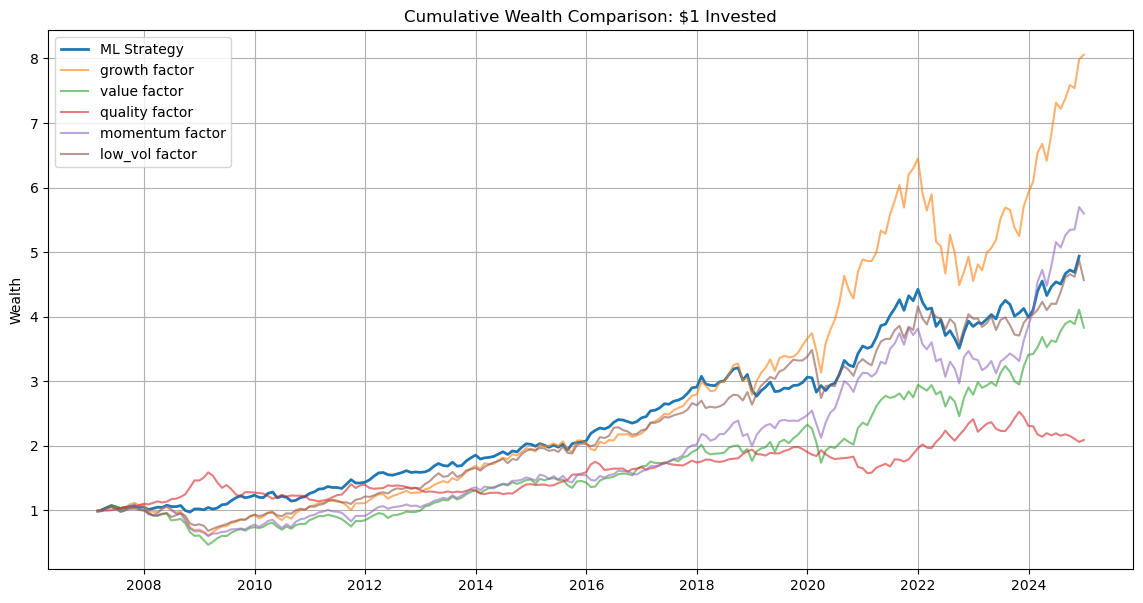

In [32]:
plt.figure(figsize=(14,7))

plt.plot(equity.index, equity["ML Strategy"], label="ML Strategy", linewidth=2)
# plt.plot(equity.index, equity["S&P 500 Equal-weight"], label="S&P 500 Equal-weight", linewidth=2)
# plt.plot(equity.index, equity["Fama French Equal-Weight"], label="Fama French Equal-Weight", linewidth=2)

for col in ["growth", "value", "quality", "momentum", "low_vol"]:
    cum = (1 + df_factor_returns[col]).cumprod()
    plt.plot(cum.index, cum, label=f"{col} factor", alpha=0.6)

plt.title("Cumulative Wealth Comparison: $1 Invested")
plt.ylabel("Wealth")
plt.legend()
plt.grid(True)
plt.show()

=== Regime Confusion Matrix ===


array([[104,  29],
       [ 28,  52]])

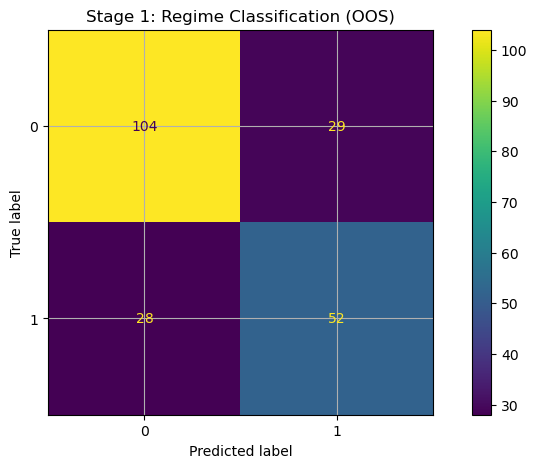

Factor hit-rate: 0.225


In [33]:
cm_reg = confusion_matrix(bt["regime_true"], bt["regime_pred"])
print("=== Regime Confusion Matrix ===")
display(cm_reg)
ConfusionMatrixDisplay(cm_reg).plot()
plt.title("Stage 1: Regime Classification (OOS)")
plt.show()

hit_rate = (bt["factor_pred"] == bt["factor_true"]).mean()
print(f"Factor hit-rate: {hit_rate:.3f}")

In [34]:
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M")
filename = f"backtest_{train_window_months}_{refit_frequency_months}_results_{ts}.csv"
bt.to_csv(filename)
print(f"Saved results → {filename}")

Saved results → backtest_204_1_results_20251126_1144.csv
